In [16]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import time

c:\Users\sgtas\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


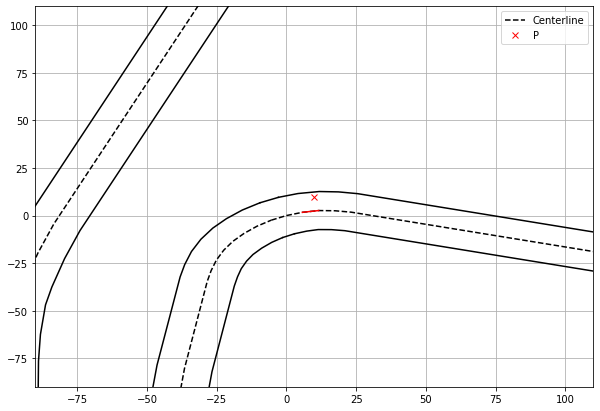

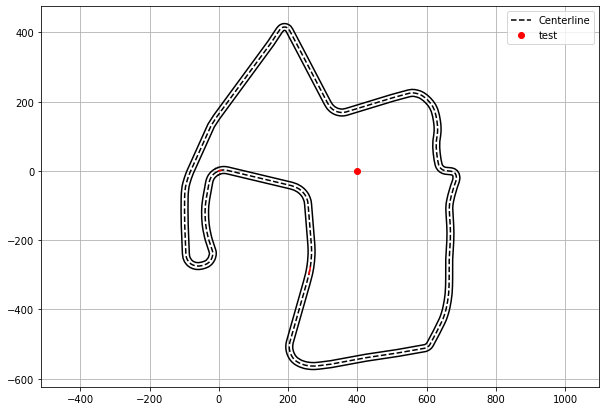

In [17]:
from CarParameters import CarParam
from Track import Track
plt.rcParams['figure.figsize'] = [10, 7]
        
track = Track('C:/Users/sgtas/Desktop/autonomous_car/track_data.csv')
track.bearing_align(0.1, -0.1)
mindex, mindist, t = track.find_nearest_edge([10.0, 10.0])
track.plot_track(edges=[mindex], points=[[10, 10]], point_formats=['rx'], point_labels=['P'], window_center=[10, 10], window_size=200)
track.plot_track(edges=[0,20], points=[[400, 0]], point_labels=['test'])

In [18]:
track.track_df.columns

Index(['x', 'y', 'z', 'xn', 'yn', 'zn', 'heading', 'dist', 'uv', 'cum_dist',
       'inner_x', 'inner_y', 'outer_x', 'outer_y'],
      dtype='object')

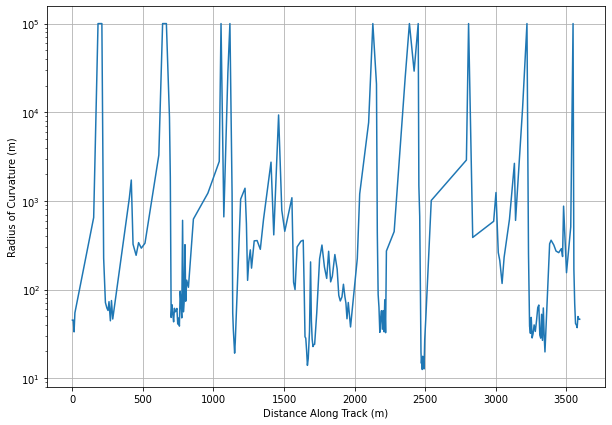

In [19]:
track.computeRadiusOfCurvature(2)
rocs = []
for i in range(len(track.track_df)):
    rocs.append(track.computeRadiusOfCurvature(i))

track.track_df['roc'] = rocs

plt.plot(track.track_df['cum_dist'], track.track_df['roc'])
plt.yscale("log")
plt.ylabel("Radius of Curvature (m)")
plt.xlabel('Distance Along Track (m)')
plt.grid()

Text(0, 0.5, 'Max Speed (m/s)')

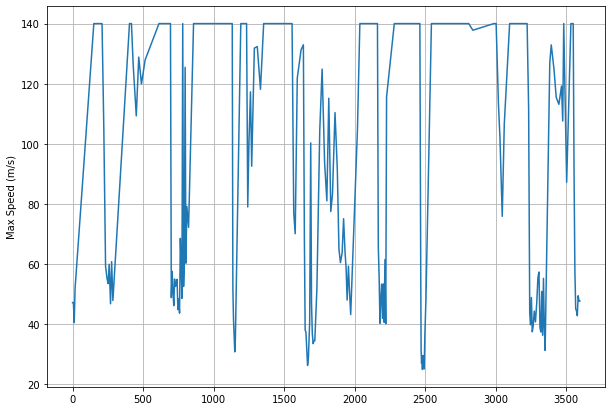

In [20]:
# get maximum speeds of each segment based on ROCs
mph_to_mps = 0.44704
max_speed = 140.0 * mph_to_mps
max_accel = 9.81

mss = track.track_df.apply(lambda x: min(max_speed, math.sqrt(x['roc'] * max_accel)), axis=1)
track.track_df['speed limit'] = mss

plt.plot(track.track_df['cum_dist'], track.track_df['speed limit'] / mph_to_mps)                          
plt.grid()
plt.ylabel('Max Speed (m/s)')

cntr:  1
cntr:  2
cntr:  3
cntr:  4
cntr:  5
cntr:  6
cntr:  7
cntr:  8
cntr:  9
cntr:  10
cntr:  11
cntr:  12
cntr:  13
cntr:  14


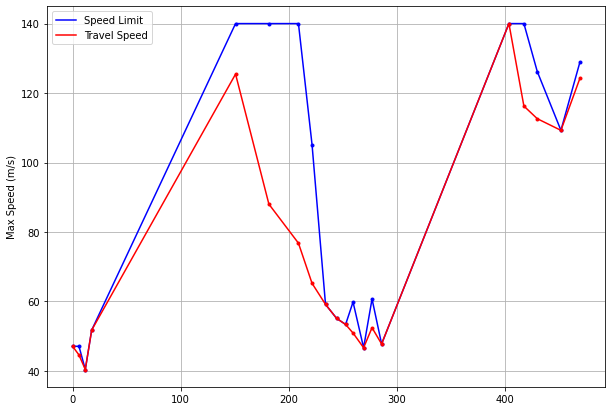

In [60]:
'''Next step is to identify a desired speed / acceleration as a function of time'''
# this should start as a backward pass - go from the speed limit of the next node to find out what
# the maximum speed of this incoming  node is. Repeat until no changes are made

carParam = CarParam()

def back_propagate_speed_limits(track, carParams):
    # start at edge 0 and go to end - 1
    spds = track.track_df['speed limit'].to_list()
    flag = True
    cntr = 0
    while flag:
        cntr += 1
        print("cntr: ", cntr)
        flag = False
        for i in range(len(spds) - 1):
            vi = spds[i+1]
            d = track.track_df['dist'][i]
            vf = math.sqrt(vi**2 - 2.0*carParam.max_braking_accel*d)
            if vf < spds[i]:
                spds[i] = vf
                flag = True        
    return spds
    


track.track_df['speed'] = back_propagate_speed_limits(track, carParam)
rng_l = 0
rng_u = 20#len(track.track_df)
plt.plot(track.track_df['cum_dist'][rng_l:rng_u], track.track_df['speed limit'][rng_l:rng_u] / mph_to_mps, 'b', label='Speed Limit')
plt.plot(track.track_df['cum_dist'][rng_l:rng_u], track.track_df['speed limit'][rng_l:rng_u] / mph_to_mps, 'b.', label='_Speed Limit')
plt.plot(track.track_df['cum_dist'][rng_l:rng_u], track.track_df['speed'][rng_l:rng_u] / mph_to_mps, 'r', label='Travel Speed')
plt.plot(track.track_df['cum_dist'][rng_l:rng_u], track.track_df['speed'][rng_l:rng_u] / mph_to_mps, 'r.', label='_Travel Speed')
                        
plt.grid()
plt.ylabel('Max Speed (m/s)')
plt.legend()

In [53]:
vi = 140.0#track.track_df['speed limit'][i+1]
d = 50.0#track.track_df['dist'][i]
print(carParam.max_braking_accel)
vf = math.sqrt(vi**2 + 2.0*carParam.max_braking_accel*d)
min(vf, 140.0)

-6.0


137.84048752090223

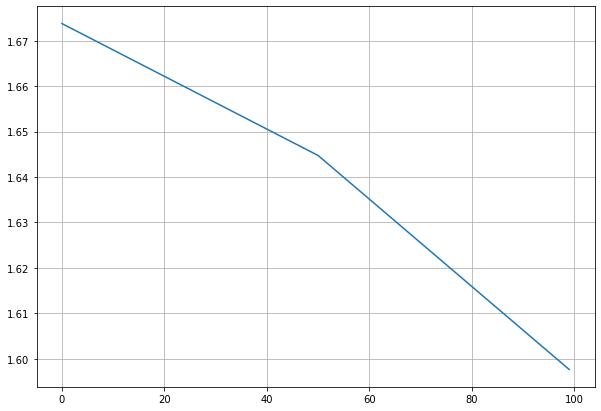

In [23]:

'''Here i want to interpolate between edges'''

# take in t along edge
# edge index
# get weighting factor for speed / heading, etc.

def interp_between_edges(track, i, t):
    
    if t < 0.5 and i>0:
        mt = t+0.5
        em1 = track.bearing_align(track.track_df.iloc[i].heading, track.track_df.iloc[i-1]['heading'])
        return mt*track.track_df.iloc[i].heading + (1-mt)*em1
    elif t > 0.5 and i < len(track.track_df)-1:
        mt = t-0.5
        ep1 = track.bearing_align(track.track_df.iloc[i].heading, track.track_df.iloc[i+1].heading)     
        return (1-mt)*track.track_df.iloc[i].heading + mt*ep1
    else:
        return track.track_df.iloc[i].heading
    
    
ws = []
for t in range(100):
    ws.append(track.interp_between_edges(100, t/100, 'heading'))
    
plt.plot(ws)
plt.grid()